# Regularized Linear Regression

Un modelo lineal regularizado es una versión de un modelo lineal que incluye un elemento en su función para evitar el overfitting y mejorar la capacidad de aprendizaje del modelo.

El objetivo de un modelo lineal es el de encontrar la relación entre las variables de entrada y la variable de salida. Pero si un modelo lineal tiene demasiados parámetros o si los datos son muy ruidosos, puede suceder que el modelo se ajuste demamasiado a los datos de entrenamiento, lo que provoca un claro sobreajuste (overfitting) y dificulta generalizar bien a los nuevos datos.




Los datos con los que vamos a trabajar son datos sociodemográficos y de recursos de salud por condado en los Estados Unidos en los años 2018 y 2019.

Para ello es necesario establecer una variable objetivo (relacionada con la salud) para llevar a cabo el análisis.

### ¿Existe alguna relación entre los recursos sanitarios y los datos sociodemográficos?

In [4]:
#Importamos las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline

In [5]:
# Vemos el dataframe
health_data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv', sep = ',')
health_data.head(5)

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


In [6]:
# Vemos los tipos de datos y el número de valores y columnas
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [7]:
# Identificamos el tipo de datos de cada columna
data_types = health_data.dtypes

# Separamos las columnas categóricas de las numéricas
categorical_columns = list(data_types[data_types == object].index)
numeric_columns = list(data_types[data_types != object].index)

print(categorical_columns)
print(numeric_columns)

['COUNTY_NAME', 'STATE_NAME']
['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018', 'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2018', 'Less than a high school diploma 2014-18', 'High school diploma only 2014-18', "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18

In [8]:
# Factorizamos las columnas de datos categóricos para poder trabajar con ellas
health_data['COUNTY_NAME'] = pd.factorize(health_data['COUNTY_NAME'])[0]
health_data['STATE_NAME'] = pd.factorize(health_data['STATE_NAME'])[0]

In [9]:
# Hacemos el escalado de valores, donde normalizamos los datos para que puedan ser comparables entre sí
from sklearn.preprocessing import StandardScaler

num_variables = [col for col in health_data.columns if col != 'anycondition_prevalence']

''' num_variables = []
for col in data_combined.columns:
    if col != 'anycondition_prevalence':
        num_variables.append(col)'''

scaler = StandardScaler()
scaled_features = scaler.fit_transform(health_data[num_variables])
total_data_scal = pd.DataFrame(scaled_features, index = health_data.index, columns = num_variables)
total_data_scal['anycondition_prevalence'] = health_data['anycondition_prevalence']

In [10]:
# Dividimos entre train y test

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest

x = total_data_scal[num_variables]
y = health_data['anycondition_prevalence']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state = 42)
train_ids = X_train.index.values
test_ids = X_test.index.values

In [11]:
# Seleccionamos las variables

selector = SelectKBest(k = 36)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]
X_test_selected = X_test[selected_features]
X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

In [12]:
# Volvemos a juntar train y test

data_train_combined = pd.concat([X_train_filtered, y_train], axis = 1)
data_test_combined = pd.concat([X_test_filtered, y_test], axis = 1)
data_train_combined.index = train_ids
data_test_combined.index = test_ids
data_combined = pd.concat([data_train_combined, data_test_combined])

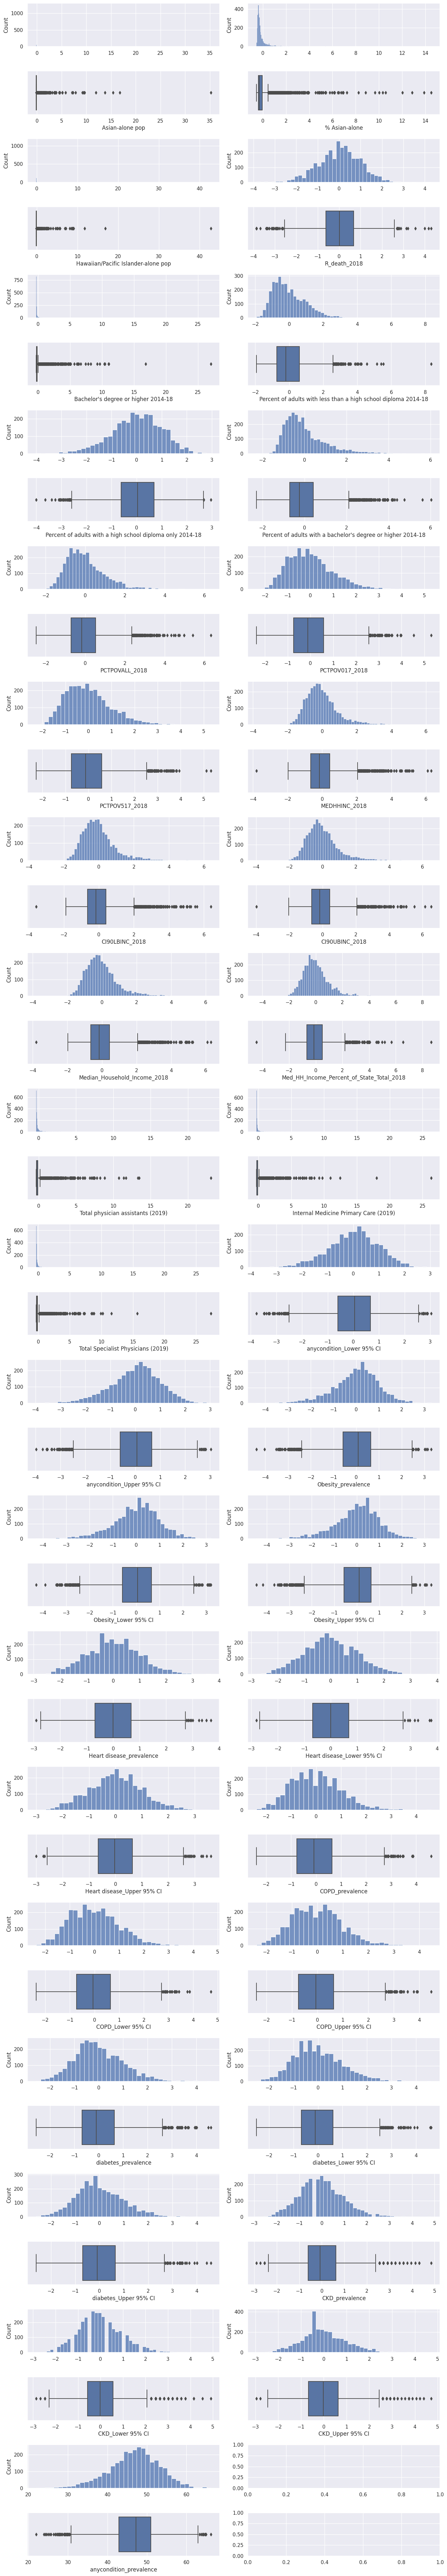

In [13]:
# Hacemos el análisis exploratorio de datos
column_names = data_combined.columns
sns.set()
fig, axis = plt.subplots(38,2, figsize = (14, 80))

for i, col_name in enumerate(column_names):
    if i % 2 == 0 :
        sns.histplot(ax = axis[i, 0], data= data_combined, x = col_name).set(xlabel = None)
        sns.boxplot(ax = axis[i + 1, 0 ], data = data_combined, x = col_name)
    else :
        sns.histplot(ax = axis[i - 1, 1], data = data_combined, x = col_name).set(xlabel = None)
        sns.boxplot(ax = axis[i , 1 ], data = data_combined, x = col_name)
plt.tight_layout()
plt.show()

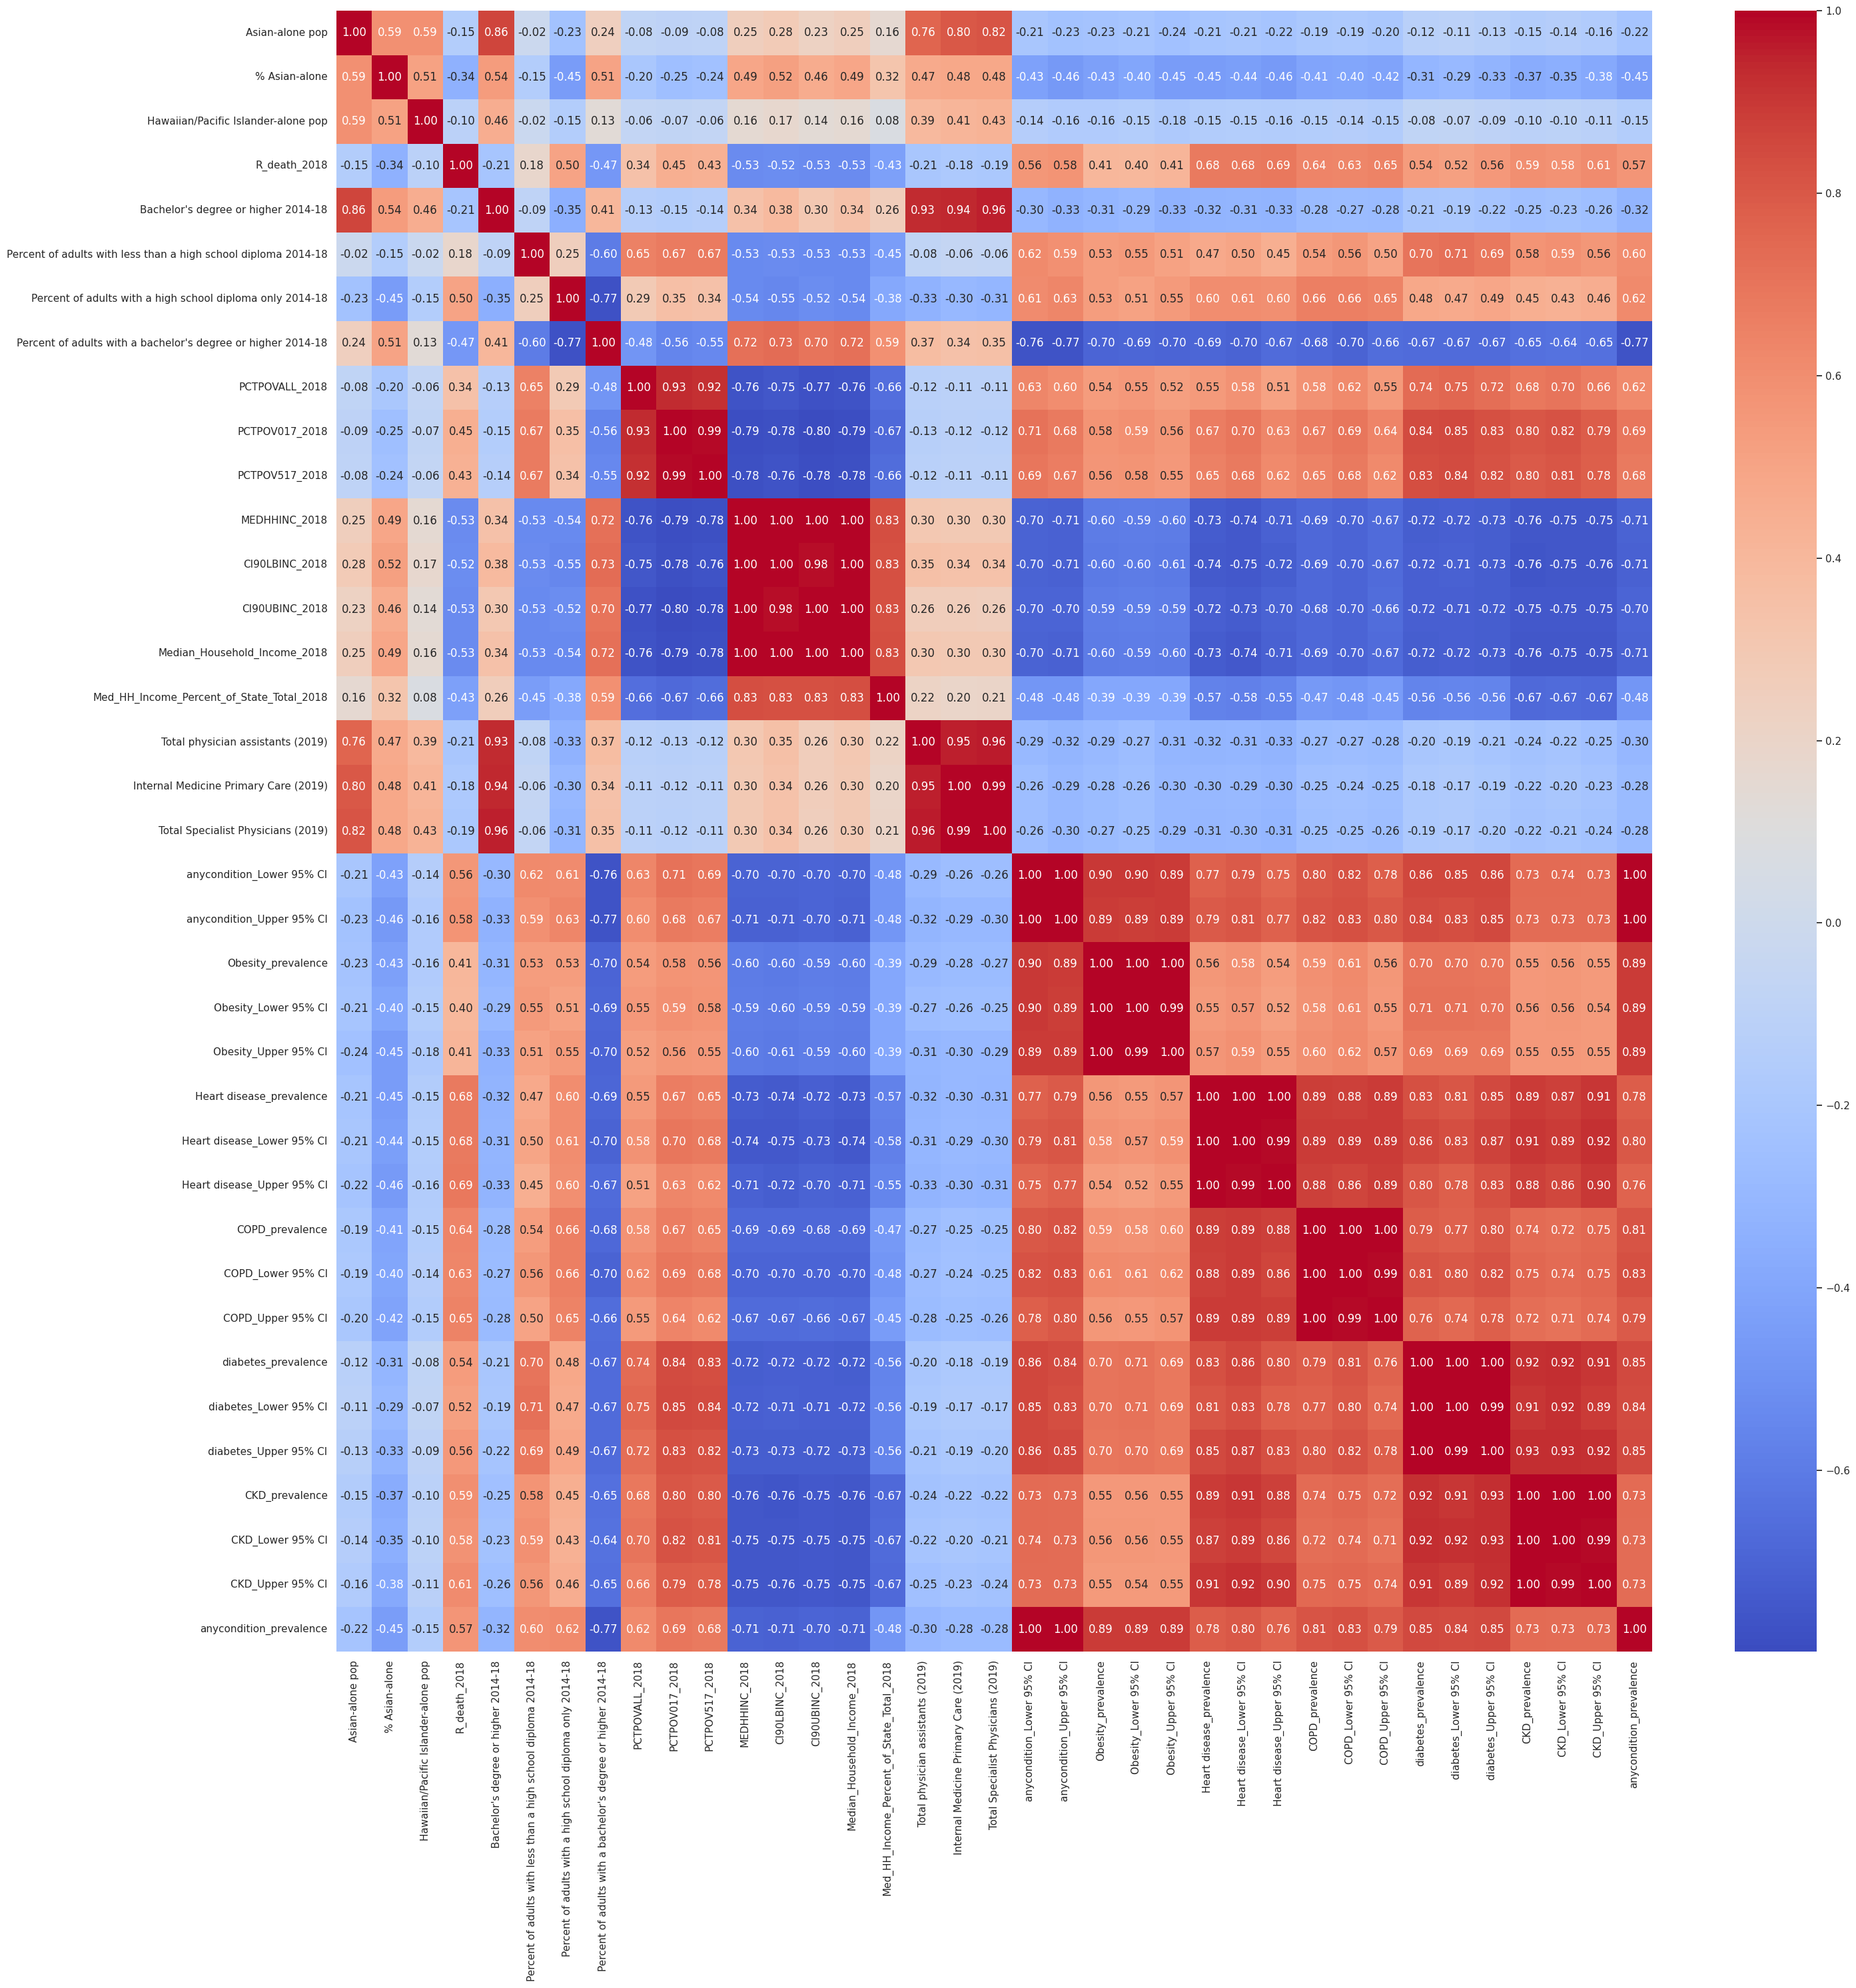

In [14]:
# Vemos el mapa de correlaciones entre todas las variables
corr_matrix = data_combined.corr()

fig, ax = plt.subplots(figsize = (30,30))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', ax = ax)

plt.tight_layout()

plt.show()

In [15]:
# Vemos si el dataset tiene valores duplicados
print(health_data[health_data.duplicated()])


Empty DataFrame
Columns: [fips, TOT_POP, 0-9, 0-9 y/o % of total pop, 19-Oct, 10-19 y/o % of total pop, 20-29, 20-29 y/o % of total pop, 30-39, 30-39 y/o % of total pop, 40-49, 40-49 y/o % of total pop, 50-59, 50-59 y/o % of total pop, 60-69, 60-69 y/o % of total pop, 70-79, 70-79 y/o % of total pop, 80+, 80+ y/o % of total pop, White-alone pop, % White-alone, Black-alone pop, % Black-alone, Native American/American Indian-alone pop, % NA/AI-alone, Asian-alone pop, % Asian-alone, Hawaiian/Pacific Islander-alone pop, % Hawaiian/PI-alone, Two or more races pop, % Two or more races, POP_ESTIMATE_2018, N_POP_CHG_2018, GQ_ESTIMATES_2018, R_birth_2018, R_death_2018, R_NATURAL_INC_2018, R_INTERNATIONAL_MIG_2018, R_DOMESTIC_MIG_2018, R_NET_MIG_2018, Less than a high school diploma 2014-18, High school diploma only 2014-18, Some college or associate's degree 2014-18, Bachelor's degree or higher 2014-18, Percent of adults with less than a high school diploma 2014-18, Percent of adults with a hig

In [26]:
# Dividimos el dataframe de nuevo en train y test
num_variables = [col for col in data_combined.columns if col != 'anycondition_prevalence']

''' num_variables = []
for col in data_combined.columns:
    if col != 'anycondition_prevalence':
        num_variables.append(col)'''

x = data_combined.drop('anycondition_prevalence', axis = 1)
y = data_combined['anycondition_prevalence']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [27]:
# Se aplica el método Kbest, donde se escogerán las características más relevantes del dataset en relación con nuestra variable objetivo
from sklearn.feature_selection import SelectKBest, f_regression
selection_model = SelectKBest(f_regression, k = 6)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train.head()

,anycondition_Lower 95% CI,anycondition_Upper 95% CI,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,diabetes_Upper 95% CI
0,-0.637191,-0.648577,0.438560,0.446677,0.394395,-1.895542
1,-1.014030,-1.024682,-1.177782,-1.121488,-1.222259,-0.337677
2,-2.003232,-1.980616,-2.329150,-2.308812,-2.314593,-1.506075
3,-0.370263,-0.413511,0.925677,0.961931,0.896869,-1.470669
4,-0.260352,-0.272472,0.549269,0.581091,0.503629,-1.010391


In [28]:
# Aplicamos la regresión lineal para entender la relación entre las variables obtenidas por el método Kbest con nuestra variable objetivo
from sklearn.linear_model import LinearRegression # Importamos el modelo de regresión lineal
from sklearn.metrics import mean_squared_error, r2_score # Importamos las métricas de evaluación mean_squared_error y r2_score

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Error cuadrático medio:", mse)
print('Coeficiente de determinación:', r2)

Error cuadrático medio: 0.00446009032176489
Coeficiente de determinación: 0.999888812649135


In [29]:
# Modelo lineal regularizado de Lasso (L1): Añade una penalización igual al valor absoluto de la magnitud de los coeficientes.
# Puede resultar en coeficientes iguales a cero, lo que indica que la característica correspondiente no se utiliza en el modelo.

from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.01, max_iter=300) # alpha: Este es el hiperparámetro de regularización. Controla cuánto queremos penalizar los coeficientes altos.
                                              # Un valor más alto aumenta la regularización y por lo tanto los coeficientes del modelo tienden a ser más pequeños.
                                              # Por el contrario, un valor más bajo la reduce y permite coeficientes más altos. El valor por defecto es 1.0 y su rango de valores va desde 0.0 hasta infinito.
                                              # max_iter: Es el número máximo de iteraciones del modelo

lasso_model.fit(X_train, y_train)

selected_features = X_train.columns[lasso_model.coef_ != 0]

y_pred = lasso_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e+01, tolerance: 1.025e+01
  model = cd_fast.enet_coordinate_descent(


In [30]:
selected_features

Index(['anycondition_Lower 95% CI', 'anycondition_Upper 95% CI'], dtype='object')

In [31]:
y_pred

array([41.48926929, 43.73081886, 50.6943492 , 44.84405924, 47.30637097,
       47.25765168, 57.20646344, 44.99798261, 54.90325209, 49.33751237,
       52.95919527, 54.15434323, 36.10333794, 52.8026834 , 50.6917607 ,
       47.83451766, 45.29806385, 54.89030959, 58.54000378, 51.15611932,
       33.49227985, 49.37070066, 55.31112591, 48.6424998 , 52.15121312,
       48.34241856, 50.2045678 , 51.20483861, 46.68291198, 60.84321513,
       37.60892115, 46.54451961, 48.23462598, 52.35385578, 47.46029434,
       60.78931884, 38.04998326, 55.89316889, 43.29234524, 42.27913194,
       49.60440532, 45.19544827, 42.95648721, 49.54015503, 42.88188292,
       36.3033921 , 35.74159491, 50.95088816, 51.59200443, 39.35033531,
       51.01513845, 48.04233732, 47.98844103, 52.34609028, 41.04303018,
       38.64238025, 60.29694894, 54.54668606, 48.84514246, 49.64794761,
       33.84108038, 46.84977785, 51.55622764, 56.9037937 , 38.75017283,
       53.25151101, 58.60684257, 54.23883931, 46.40095024, 36.75

In [32]:
print(f"Selected Features: {selected_features}")
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Selected Features: Index(['anycondition_Lower 95% CI', 'anycondition_Upper 95% CI'], dtype='object')
Mean squared error: 0.00477111084133408
Coefficient of determination: 0.9998810590959241


¿Qué es un coeficiente?

Un coeficiente es un número que acompaña a una variable. Indica cómo se relaciona esa variable con una ecuación o expresión. En otras palabras, es un valor que ayuda a medir o cuantificar la influencia de algo en un contexto específico.